In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
from pathlib import Path

In [2]:
PATH = Path('../input/')

In [3]:
def return_label(fileName):
    df = pd.read_csv(filepath_or_buffer=PATH/fileName)
    if fileName!='test.csv':
        label = np.array(df['label'])
        data = np.array(df[df.columns[1:]], dtype=np.float)
        new_data = np.reshape(a=data, newshape=(data.shape[0], 28, 28))
        return new_data, label
    else:
        data = np.array(df, dtype=np.float)
        new_data = np.reshape(a=data, newshape=(data.shape[0], 28, 28))
        return new_data

In [4]:
trainData, trainLabel = return_label('train.csv')
testData = return_label('test.csv')

In [5]:
trainData = trainData/255.
trainData = (trainData-0.5)/0.5

testData = testData/255.
testData = (testData-0.5)/0.5

trainData = torch.from_numpy(trainData).cuda()
testData = torch.from_numpy(testData).cuda()
trainData, testData = trainData.type(torch.FloatTensor), testData.type(torch.FloatTensor)

In [6]:
trainData

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        ...,

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]

In [7]:
trainData.shape

torch.Size([42000, 28, 28])

In [8]:
trainData = trainData.unsqueeze_(dim=1)
testData = testData.unsqueeze_(dim=1)

In [9]:
trainData.shape

torch.Size([42000, 1, 28, 28])

In [10]:
trainDataset = torch.utils.data.TensorDataset(trainData, torch.from_numpy(trainLabel))
train_dl = torch.utils.data.DataLoader(trainDataset, batch_size=100, shuffle=False, num_workers=4)

test_dl = torch.utils.data.DataLoader(testData, batch_size=100, shuffle=False, num_workers=4)

In [11]:
print(len(trainData), len(testData))

42000 28000


In [12]:
def num_classes(loader):
    classCount = [0]*10
    for batch_id, (images, labels) in enumerate(loader):
        for label in labels:
            classCount[int(label)]+=1
    return classCount

Text(0.5,1,'Train Set')

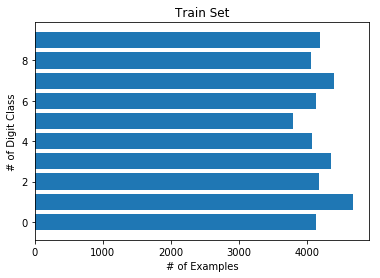

In [13]:
classes = [i for i in range(10)]
classCount = num_classes(train_dl)
fig, ax = plt.subplots()
ax.barh(y=classes, width=classCount)
ax.set_xlabel('# of Examples')
ax.set_ylabel('# of Digit Class')
ax.set_title('Train Set')

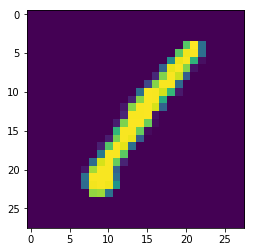

In [14]:
temp = train_dl.dataset[0][0].numpy()
temp = np.reshape(temp, (temp.shape[1], temp.shape[2]))
plt.imshow(temp)

In [15]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(1024, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 1)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [16]:
n1 = Model().cuda()
n1

Model(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [17]:
def train(model, mode, decay, criterion, dataloader, optimizer, dictionary, num_epochs=30):    
    totalLoss = []
    totalLRs = []
    correct = 0
    total = 0
    LR = 0
    for epoch in range(num_epochs):
        if(decay == True):
            for param in optimizer.param_groups:
                LR = param['lr'] * (0.1**(epoch//7))
                param['lr'] = LR
            totalLRs.append(LR)
        print("Epoch = {}/{} ".format(epoch,num_epochs),end=" ")
        for batch_id,(image, label) in enumerate(dataloader):
            if(mode == True):
                optimizer.zero_grad()
                image = torch.autograd.Variable(image)
                label = torch.autograd.Variable(label)
                image = image.cuda()
                label = label.cuda()
            else:
                image = torch.autograd.Variable(image)
                image = image.cuda()
            output = model.forward(image)
            if(mode == True):
                loss = criterion(output,label)
            _, predictated = torch.max(output.data,1)   
            if(mode == True):
                correct += (predictated == label.data).sum()
                total += label.size(0)
                loss.backward()
                optimizer.step()
            del image,label
        torch.cuda.empty_cache()
        print("Loss = {:.5f}".format(loss.item()))
        totalLoss.append(loss.item())
    dictionary['totalLoss'] = totalLoss
    dictionary['correct'] = correct
    dictionary['totalSize'] = total
    dictionary['totalLRs'] = totalLRs
    return model,dictionary

In [18]:
optimizer = torch.optim.SGD(n1.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss().cuda()

In [19]:
dictModel = {}
n1, dictModel = train(model=n1, mode=True, decay=True, 
                      criterion=criterion, dataloader=train_dl, optimizer=optimizer, 
                      dictionary=dictModel, num_epochs=50)

Epoch = 0/50  Loss = 0.11982
Epoch = 1/50  Loss = 0.07111
Epoch = 2/50  Loss = 0.03547
Epoch = 3/50  Loss = 0.01577
Epoch = 4/50  Loss = 0.01086
Epoch = 5/50  Loss = 0.00915
Epoch = 6/50  Loss = 0.03564
Epoch = 7/50  Loss = 0.00059
Epoch = 8/50  Loss = 0.00053
Epoch = 9/50  Loss = 0.00053
Epoch = 10/50  Loss = 0.00053
Epoch = 11/50  Loss = 0.00053
Epoch = 12/50  Loss = 0.00053
Epoch = 13/50  Loss = 0.00053
Epoch = 14/50  Loss = 0.00053
Epoch = 15/50  Loss = 0.00053
Epoch = 16/50  Loss = 0.00053
Epoch = 17/50  Loss = 0.00053
Epoch = 18/50  Loss = 0.00053
Epoch = 19/50  Loss = 0.00053
Epoch = 20/50  Loss = 0.00053
Epoch = 21/50  Loss = 0.00053
Epoch = 22/50  Loss = 0.00053
Epoch = 23/50  Loss = 0.00053
Epoch = 24/50  Loss = 0.00053
Epoch = 25/50  Loss = 0.00053
Epoch = 26/50  Loss = 0.00053
Epoch = 27/50  Loss = 0.00053
Epoch = 28/50  Loss = 0.00053
Epoch = 29/50  Loss = 0.00053
Epoch = 30/50  Loss = 0.00053
Epoch = 31/50  Loss = 0.00053
Epoch = 32/50  Loss = 0.00053
Epoch = 33/50  Loss 

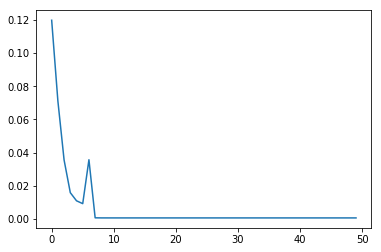

In [20]:
plt.plot(dictModel['totalLoss'])

In [23]:
optimizer = torch.optim.SGD(n1.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss().cuda()

dictModel = {}
n1, dictModel = train(model=n1,mode=True,decay=False,criterion=criterion,dataloader=train_dl,
                            optimizer=optimizer,dictionary=dictModel,num_epochs=20)

Epoch = 0/20  Loss = 0.00052
Epoch = 1/20  Loss = 0.00049
Epoch = 2/20  Loss = 0.00046
Epoch = 3/20  Loss = 0.00045
Epoch = 4/20  Loss = 0.00044
Epoch = 5/20  Loss = 0.00043
Epoch = 6/20  Loss = 0.00043
Epoch = 7/20  Loss = 0.00042
Epoch = 8/20  Loss = 0.00041
Epoch = 9/20  Loss = 0.00040
Epoch = 10/20  Loss = 0.00040
Epoch = 11/20  Loss = 0.00039
Epoch = 12/20  Loss = 0.00039
Epoch = 13/20  Loss = 0.00038
Epoch = 14/20  Loss = 0.00037
Epoch = 15/20  Loss = 0.00036
Epoch = 16/20  Loss = 0.00035
Epoch = 17/20  Loss = 0.00035
Epoch = 18/20  Loss = 0.00034
Epoch = 19/20  Loss = 0.00033


Text(0.5,1,'Train Dataset')

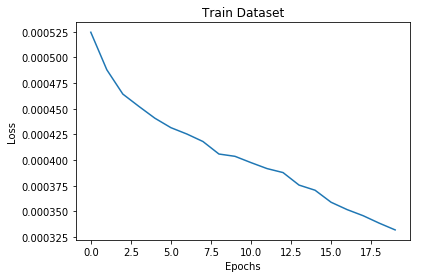

In [24]:
plt.plot(dictModel['totalLoss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Dataset')


In [25]:
avgLossTest = []
totalPrediction = []
for id, image in enumerate(test_dl):
    image = torch.autograd.Variable(image).cuda()
    output = n1(image)
    _, predictated = torch.max(output.data, 1)
    totalPrediction.append(predictated)

In [32]:
len(totalPrediction)

280

In [33]:
len(testData)

28000

(<matplotlib.image.AxesImage at 0x7f2e29ea6a58>, tensor(2, device='cuda:0'))

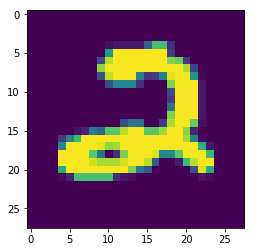

In [40]:
plt.imshow(test_dl.dataset[0][0]), totalPrediction[0][0]

In [43]:
test_dl.dataset

tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.000

(<matplotlib.image.AxesImage at 0x7f2e29e82c88>, tensor(0, device='cuda:0'))

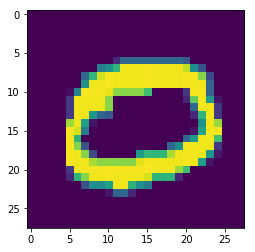

In [46]:
plt.imshow(test_dl.dataset[1][0]), totalPrediction[1][0]

In [47]:
temp = [list(x.cpu().numpy()) for x in totalPrediction]
Label = []
for x in temp:
    for y in x:
        Label.append(y)
ImageId = [t for t in range(1, 28001)]
len(ImageId)
dfDict = {'ImageId':ImageId, 'Label':Label}
df = pd.DataFrame(dfDict)
df.to_csv('submission.csv', index=False)